# ITC 6001 - PROJECT - Introduction To Big Data #
## Drouvas Panagiotis, Dendrinos Theodoros, Kontoudakis Nikolaos ##

In [3]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
print(os.getcwd());
# change the following on your pc!
projectPath = "/home/nikos/Documents/6001_project"
dataPath = projectPath + "/ml-100k/u.data"
userPath = projectPath + "/ml-100k/u.user";

#outlier sigma limit
oSL= 3

/home/nikos/Documents/6001_project


# Q1: Exploring the Data

## Read the data

In [7]:
uData = pd.read_csv(dataPath, sep= '\t', header= None, names=["userId", "itemId", "rating", "timestamp"])
pivotedData = uData.pivot(index="userId", columns="itemId", values="rating").reset_index().rename_axis(None, axis=1).set_index(keys="userId", drop= "True")
#make it easier to access the column names
pivotedData.columns = pivotedData.columns.map(str)

In [8]:
# #free testing area

# display(pivotedData[pivotedData.userId== 916])
# pivotedData.to_csv("export.csv", sep=',', encoding='utf-8', index=False, header=True)
# diferentPivotMovies = uData.pivot(index="itemId", columns="userId", values="rating").reset_index().rename_axis(None, axis=1)
# display(pivotedData)
# print(diferentPivotMovies)

# uData[uData.userId == 943].sum()
# pivotedData.loc[[943]].sum(axis=1)

## Remove outliers ##

In [10]:
# for movies
movieRatingsCount = pivotedData.notna().sum(axis= 0)
movieRatingCountMu = np.mean(movieRatingsCount)
movieRatingSigma = np.std(movieRatingsCount)
ZMovieScore = ((movieRatingsCount - movieRatingCountMu)) / movieRatingSigma
lessThan10 = movieRatingsCount < 9

In [11]:
# for users
ratingsCount = pivotedData.notna().sum(axis= 1)
mu = np.mean(ratingsCount)
sigma = np.std(ratingsCount)
pivotedData['ZScore'] = ((ratingsCount - mu) / sigma)

#z scores for both movies and users have been calculated in advance in order to be fair.
#otherwise if we droped some users and later calculating the movie ZScore we would also drop their ratings which would result in mistakenly calculating some movies as outliers 
removedOutliers = pivotedData[(pivotedData.ZScore > -oSL) & (pivotedData.ZScore < oSL)].drop(columns= ["ZScore"])
movieOutliers = ZMovieScore[(ZMovieScore < -oSL) | (ZMovieScore > oSL)].index
lessThan10Indexes = lessThan10[lessThan10].index
# Drop the columns from the DataFrame
removedOutliers = removedOutliers.drop(columns=movieOutliers, axis=1)
removedOutliers = removedOutliers.drop(columns=lessThan10Indexes, axis=1)

## Information ##

In [13]:
removedOutliers.describe()
# pivotedData.to_csv("original.csv", sep=',', encoding='utf-8', index=False, header=True)

,2,3,4,5,6,8,9,10,11,12,...,1471,1473,1478,1480,1483,1503,1518,1540,1615,1620
count,120.000000,83.000000,197.000000,79.000000,23.000000,210.000000,291.000000,83.00000,225.000000,255.000000,...,7.000000,8.00000,15.000000,8.000000,10.000000,8.000000,10.000000,8.00000,10.000000,9.000000
mean,3.208333,3.060241,3.543147,3.367089,3.739130,3.995238,3.893471,3.86747,3.871111,4.407843,...,2.714286,3.62500,2.866667,2.125000,3.400000,3.250000,3.000000,2.75000,3.000000,3.222222
std,0.969240,1.243023,0.971227,0.922333,1.214211,1.009513,1.046666,1.02137,1.054883,0.787662,...,1.112697,1.30247,0.990430,1.125992,1.173788,1.035098,0.816497,1.28174,1.054093,1.201850
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,2.000000,2.000000,1.00000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,4.000000,...,2.000000,3.00000,2.500000,1.000000,3.000000,2.750000,2.250000,2.00000,2.250000,3.000000
50%,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.00000,4.000000,5.000000,...,3.000000,4.00000,3.000000,2.000000,4.000000,3.000000,3.000000,2.50000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,...,3.500000,4.25000,3.500000,3.000000,4.000000,4.000000,3.750000,3.25000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,...,4.000000,5.00000,4.000000,4.000000,5.000000,5.000000,4.000000,5.00000,4.000000,5.000000


## Ploting ##
 plot the number of movies seen by each user, and the frequency of each rating

(array([ 94., 121., 107.,  65.,  62.,  65.,  66.,  31.,  41.,  50.,  36.,
         19.,  35.,  28.,  21.,  22.,  11.,  13.,  19.,  18.,  24.,  14.,
          8.,  11.,  11.,  13.,   8.,  17.,  16.,   7.,   5.,   4.,   8.,
          7.,   4.,  10.,   9.,   2.,   3.,   6.,   6.,   7.,   2.,   4.,
          3.,   4.,   3.,   0.,   8.,   5.]),
 array([  4.  ,   9.74,  15.48,  21.22,  26.96,  32.7 ,  38.44,  44.18,
         49.92,  55.66,  61.4 ,  67.14,  72.88,  78.62,  84.36,  90.1 ,
         95.84, 101.58, 107.32, 113.06, 118.8 , 124.54, 130.28, 136.02,
        141.76, 147.5 , 153.24, 158.98, 164.72, 170.46, 176.2 , 181.94,
        187.68, 193.42, 199.16, 204.9 , 210.64, 216.38, 222.12, 227.86,
        233.6 , 239.34, 245.08, 250.82, 256.56, 262.3 , 268.04, 273.78,
        279.52, 285.26, 291.  ]),
 <BarContainer object of 50 artists>)

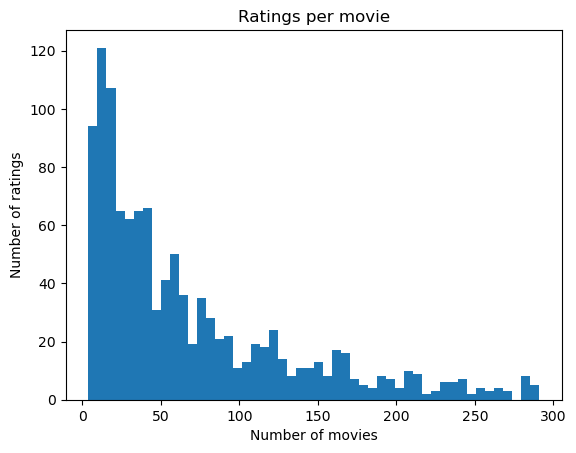

In [15]:
plt.title('Ratings per movie')
plt.xlabel("Number of movies")
plt.ylabel("Number of ratings")
plt.hist(removedOutliers.count(), bins= 50)

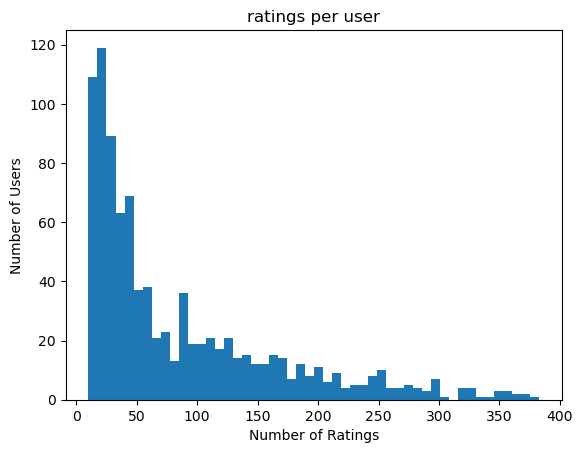

In [16]:
ratingsPerUser = removedOutliers.notnull().sum(axis=1)

ratingsPerUser.hist(bins=50)
plt.title('ratings per user')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.grid(False)
plt.show()

# Q2: Basic Recomended System

## Spliting data into train and test ##

In [19]:
#random_state property allows for repitability of the spliting
trainData= removedOutliers.sample(frac=0.8,random_state=200, axis= 0)
testData= removedOutliers.drop(trainData.index)

In [78]:
#get the number of ratings a movie has
trainDataRatingsCount = trainData.notna().sum(axis= 0)
trainData

,2,3,4,5,6,8,9,10,11,12,...,1471,1473,1478,1480,1483,1503,1518,1540,1615,1620
userId,,,,,,,,,,,,,,,,,,,,,
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recomend movies to test users

In [263]:
# we need to recomend only rated movies so there is a valid comparison

averageMovieRating = trainData.mean().sort_values(ascending= False)
recomendedMovies = pd.DataFrame()
for userIndex, row in testData.iterrows():   
    notNanCols = row.dropna().index
    #get the first 5 top rated movies that the test user has seen
    sortedCols = averageMovieRating[notNanCols].sort_values(ascending=False).index[:5]
    top_values = averageMovieRating[sortedCols].values
    recomendedMovies.loc[userIndex, sortedCols] = top_values
    
# testData.to_csv("testData.csv", sep=',', encoding='utf-8', index=True, header=True)
recomendedMovies

,169,64,114,12,178,318,272,302,320,341,...,273,182,177,321,494,1062,307,459,531,896
1,4.452632,4.449074,4.428571,4.399038,4.393617,b'',b'',b'',b'',b'',...,b'',b'',b'',b'',b'',b'',b'',b'',b'',b''
3,NaN,NaN,NaN,NaN,NaN,4.506438,4.238994,4.12766,4.117647,4.0,...,b'',b'',b'',b'',b'',b'',b'',b'',b'',b''
7,NaN,4.449074,NaN,4.399038,NaN,4.506438,NaN,NaN,NaN,NaN,...,b'',b'',b'',b'',b'',b'',b'',b'',b'',b''
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'',b'',b'',b'',b'',b'',b'',b'',b'',b''
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'',b'',b'',b'',b'',b'',b'',b'',b'',b''
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,4.452632,4.449074,4.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,4.399038,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
